In [1]:
# start by importing the necessities

from astropy.io import fits
from astropy.io import ascii
import warnings
import numpy as np
import matplotlib.pyplot as plt

### Time Keeping

In [2]:
#to keep track of the execution time
import time

time.localtime()

time.struct_time(tm_year=2025, tm_mon=11, tm_mday=7, tm_hour=12, tm_min=20, tm_sec=36, tm_wday=4, tm_yday=311, tm_isdst=0)

In [3]:
time.tzname

('CST', 'CDT')

In [4]:
time.time()

1762539636.053555

### Image shifts

In [5]:
path = '/Users/wanyan/Desktop/Astro/229/M82/reduced/'
dat_path = path + 'imput_list1.txt'

# files we need to do the alignment
sdat = ascii.read(dat_path, delimiter=" ") # reads into astropy table object sdat
sdat

<Table length=11>
     name      xsh   ysh 
    str13     int64 int64
------------- ----- -----
M82_V_63.fits     0     0
M82_V_59.fits    15    52
M82_V_60.fits    15    52
M82_V_61.fits    16     2
M82_V_62.fits     0     1
M82_V_64.fits     1   -49
M82_V_66.fits    18   -50
M82_V_67.fits    18   -51
M82_V_68.fits    19   -51
M82_V_69.fits     2   -52
M82_V_70.fits     3  -102

### Alignment

In [6]:
# number of files in the list
nfiles=np.shape(sdat)[0]

# make arrays collect the min/max x,y image bounds
# initialize these with zero
ixmax=np.zeros(nfiles, dtype=int)
ixmin=np.zeros(nfiles, dtype=int)
iymin=np.zeros(nfiles, dtype=int)
iymax=np.zeros(nfiles, dtype=int)

# record the start time so we can see how long this takes to run
start_time = time.time()

#loop through each line in the table to set limits on the image sizes
for i in range(0,nfiles):
    #read in the image
    ffile=fits.open(path+sdat['name'][i])

    #read size of images from the header
    xsz=ffile[0].header['NAXIS1']
    ysz=ffile[0].header['NAXIS2']

    # collect shifts for each image
    ixmin[i]=1+sdat['xsh'][i]
    ixmax[i]=xsz+sdat['xsh'][i]
    iymin[i]=1+sdat['ysh'][i]
    iymax[i]=ysz+sdat['ysh'][i]

# figure out the size of the composite image from the list of shifts
ixmn=np.min(ixmin)
ixmx=np.max(ixmax)
iymn=np.min(iymin)
iymx=np.max(iymax)

#size of composite
ixbig=ixmx-ixmn+1
iybig=iymx-iymn+1

# calculate and print the execution time
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.010710000991821289 seconds ---


In [7]:
#make an empty array for the combined image
cgrid=np.empty((iybig,ixbig,nfiles))
#fill it with NaNs, then replace with data
cgrid[::]=np.nan


start_time = time.time()


#shift each image
for i in range(0,nfiles): #loop through the files
    #read in the shifted data
    ffile=fits.open(path+sdat['name'][i])
    fdata=ffile[0].data
    print("Doing image ",sdat['name'][i],end="")

    for iy in range(0,iybig):
        if(np.mod(iy,1+(iybig/20))==((iybig/20)-1)) :
            print("{0:s}Doing image {1:s} {2:2d}%".format('\r',sdat['name'][i],(100*iy/iybig)),end="")
        #make sure each file contributes only where it has data
        if (iy<(iymin[i]-iymn) or iy>(iymax[i]-iymn)):
            continue
        for ix in range(0,ixbig):
            if (ix<(ixmin[i]-ixmn) or ix>(ixmax[i]-ixmn)):
                continue
            #figure out the corresponding pixel index
            ky=iy-iymin[i]+iymn
            kx=ix-ixmin[i]+ixmn

            # this also subtracts off the sky value and adds the multiplicative factor to the brightnesses are roughly equal
            # we should talk about whether this works for data where you care about the flux
            cgrid[iy,ix,i] = fdata[ky,kx]
    ffile.close()
    print("{0:s}Doing image {1:s} ...done".format('\r',sdat['name'][i]))

print("--- %s seconds ---" % (time.time() - start_time))

Doing image M82_V_63.fits ...done
Doing image M82_V_59.fits ...done
Doing image M82_V_60.fits ...done
Doing image M82_V_61.fits ...done
Doing image M82_V_62.fits ...done
Doing image M82_V_64.fits ...done
Doing image M82_V_66.fits ...done
Doing image M82_V_67.fits ...done
Doing image M82_V_68.fits ...done
Doing image M82_V_69.fits ...done
Doing image M82_V_70.fits ...done
--- 7.2688610553741455 seconds ---


In [8]:
#make a new file to collect the combined image
cfile=np.empty((iybig,ixbig))
cfile[:]=np.nan
print("Doing the composite median",end="")

start_time = time.time()

#a pixel-by-pixel median
for ix in range(0,ixbig):
    if(np.mod(ix,1+(ixbig/20))==((ixbig/20)-1)) :
        print("{0:s}Doing the composite median {1:2d}%".format("\r",(100*ix/ixbig)),end="")
    for iy in range(0,iybig):
        cfile[iy,ix]=np.nanmedian(cgrid[iy,ix,:])
print("{0:s}Doing the composite median  ...done".format("\r"))

print("--- %s seconds ---" % (time.time() - start_time))

Doing the composite median

/var/folders/jt/pmnf348x4bq6l0mthmr86gd00000gn/T/ipykernel_5281/2522963137.py:13: RuntimeWarning: All-NaN slice encountered
  cfile[iy,ix]=np.nanmedian(cgrid[iy,ix,:])


Doing the composite median  ...done
--- 8.81802487373352 seconds ---


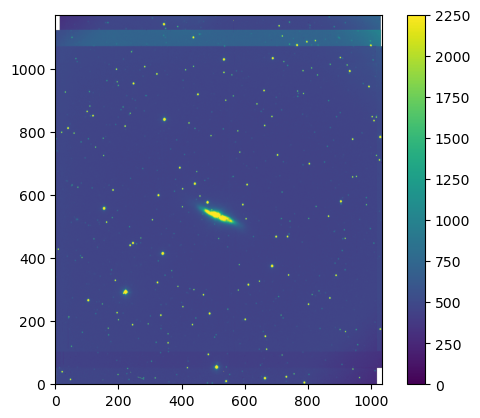

In [9]:
# show the image
plt.imshow(cfile, origin='lower', vmin=0, vmax=2250)
plt.colorbar()

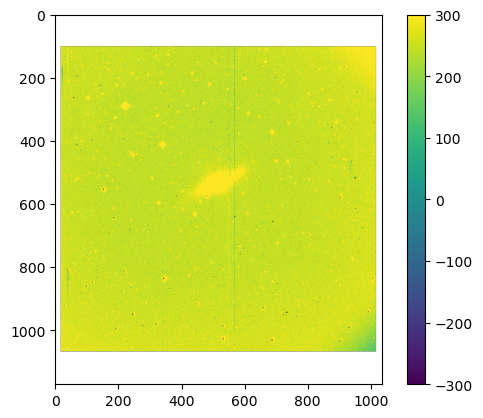

In [10]:
plt.imshow(cgrid[:,:,0]-cgrid[:,:,7], vmin=-300, vmax=300)
plt.colorbar()

### Align using For loops

In [11]:
my_array = np.arange(10)

In [12]:
np.roll(my_array, 3)

array([7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

In [13]:
my_image = fits.open('/Users/wanyan/Desktop/Astro/229/M82/reduced/m82_V_59.fits')[0].data

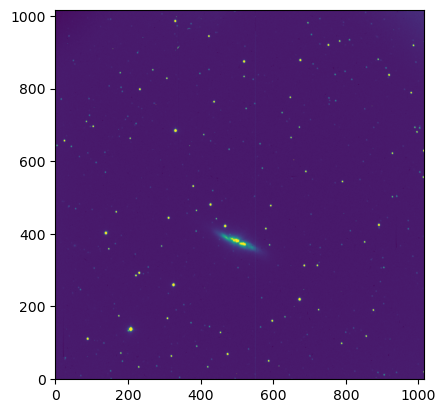

In [14]:
plt.imshow(my_image, origin='lower', vmin=50, vmax=2500)

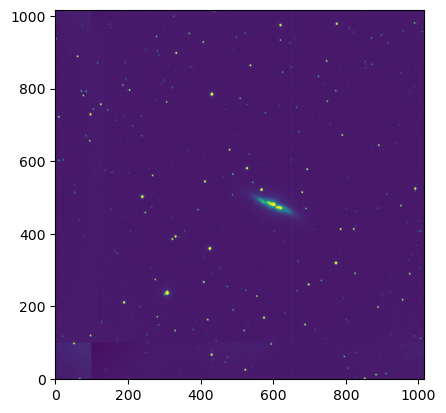

In [15]:
shifted_image = np.roll(my_image, (100, 100), axis=(0,1))
plt.imshow(shifted_image, origin='lower', vmin=50, vmax=2500)

In [16]:
xmax = sdat['xsh'].max() - sdat['xsh'].min()
xmax

19

In [17]:
ymax = sdat['ysh'].max() - sdat['ysh'].min()
ymax

154

In [18]:
padded_image = np.pad(my_image, 100, constant_values=np.nan)

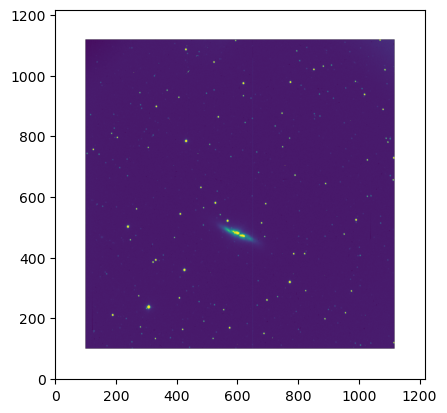

In [19]:
plt.imshow(padded_image, origin='lower', vmin=50, vmax=2500)

In [20]:
# read in the first image
ffile=fits.open(path+sdat['name'][0])

# determine the image size using the shape function
ysz, xsz = ffile[0].data.shape

# compute the shift needed for each image
xshift = sdat['xsh']
yshift = sdat['ysh']

In [22]:
#make an empty array to collect the big, shifted images
data_stack = []

start_time = time.time()

# --- SKY SUBTRACTION PART ---
sky_box = ffile[0].data[253:284, 481:524]
sky_med = np.median(sky_box)

# notice that we start with image 1! image 0 is the reference image and does not need to be shifted
for i in range(1,nfiles):
    #read in the image
    ffile = fits.open(path+sdat['name'][i])
    fdata = ffile[0].data
    fdata = fdata - sky_med

    # add NaNs around the edge of the image so we can shift the images without the data wrapping around on itself
    bgim = np.pad(fdata, 100, constant_values=np.nan)

    # shift the image -- make sure the x and y axes are correctly mapped!
    shift_im = np.roll(bgim, (xshift[i],yshift[i]), axis=(1,0))

    # add to the data stack
    data_stack.append(shift_im)

# make the data stack into an array so we can do math with it
data_stack = np.array(data_stack)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.27146410942077637 seconds ---


In [23]:
start_time = time.time()
# take the median of the image through the stack direction
# notice that we use np.nanmedian() so that we get the correct medians even where there are NaNs
imstack = np.nanmedian(data_stack, axis=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.43280625343322754 seconds ---


/var/folders/jt/pmnf348x4bq6l0mthmr86gd00000gn/T/ipykernel_5281/368899500.py:4: RuntimeWarning: All-NaN slice encountered
  imstack = np.nanmedian(data_stack, axis=0)


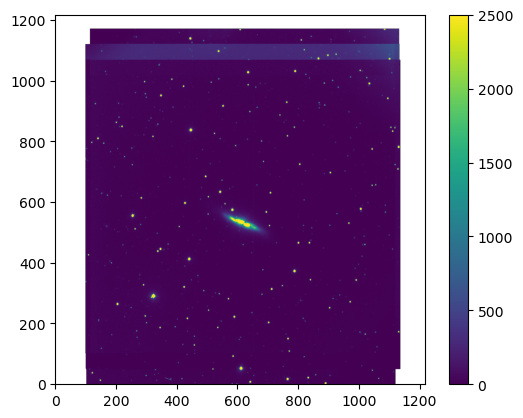

In [24]:
plt.Figure(figsize=(12,8))
plt.imshow(imstack, origin='lower', vmin=0, vmax=2500)
plt.colorbar()

### Three Color Image     

In [25]:
pip install aplpy

Note: you may need to restart the kernel to use updated packages.


In [26]:
import aplpy

/var/folders/jt/pmnf348x4bq6l0mthmr86gd00000gn/T/ipykernel_5281/3588711084.py:2: RuntimeWarning: Mean of empty slice
  im = np.nanmean(data_stack, axis=0)


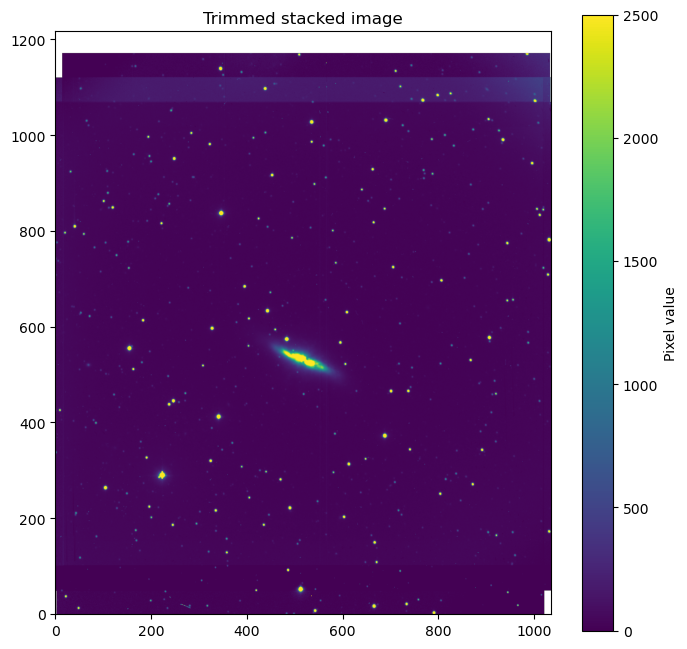

In [27]:
# Trim the Image
im = np.nanmean(data_stack, axis=0)

# Find rows/cols that contain valid data
valid_rows = np.any(~np.isnan(im), axis=1)
valid_cols = np.any(~np.isnan(im), axis=0)

# Get bounding box
rmin, rmax = np.where(valid_rows)[0][[0, -1]]
cmin, cmax = np.where(valid_cols)[0][[0, -1]]

# Trim
trimmed_im = im[rmin:rmax+1, cmin:cmax+1]

# Show result
plt.figure(figsize=(8,8))
plt.imshow(trimmed_im, origin='lower', vmin=0, vmax=2500)
plt.colorbar(label='Pixel value')
plt.title('Trimmed stacked image')
plt.show()

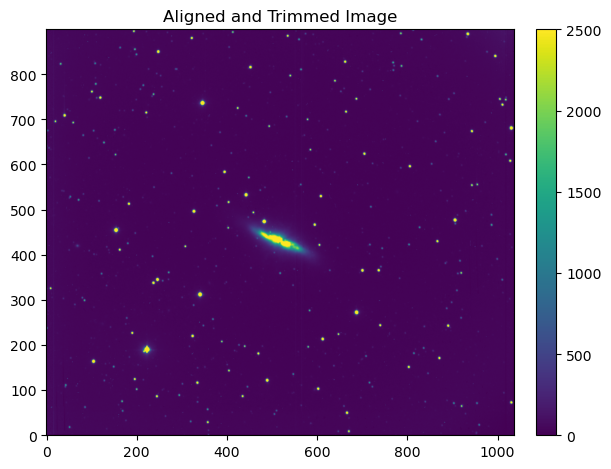

In [28]:
ymin, ymax = 100, 1000
im_ycut = trimmed_im[ymin:ymax, :]

plt.figure()
img = plt.imshow(im_ycut, origin='lower', vmin=0, vmax=2500)
plt.title('Aligned and Trimmed Image')

plt.colorbar(img, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [29]:
# From the header, I know that this is R-band Image. So I would try to give a R-band image
import os

save_dir = '/Users/wanyan/Desktop/Astro/229/M82/reduced'
save_path = os.path.join(save_dir, 'R_band_trimmed.fits')
fits.writeto(save_path, im_ycut, overwrite=True)

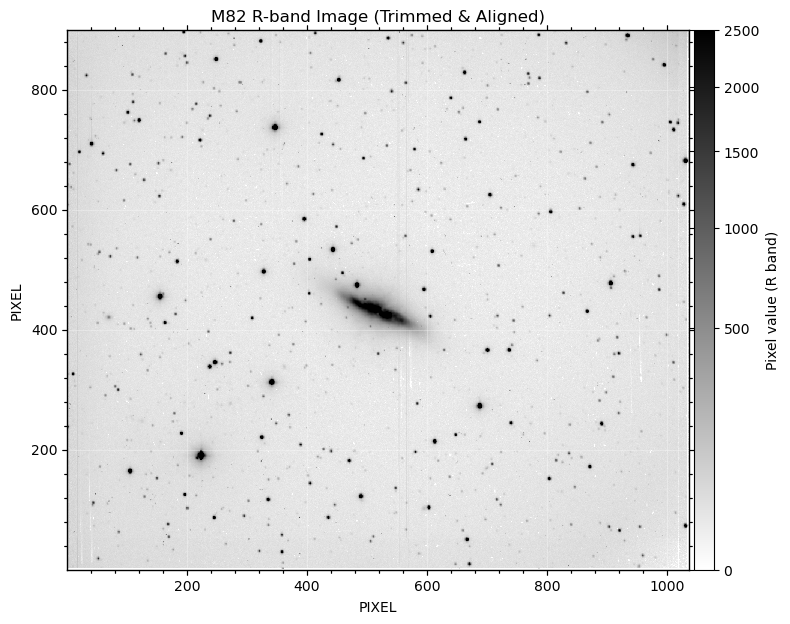

In [30]:
fits_path = '/Users/wanyan/Desktop/Astro/229/M82/reduced/R_band_trimmed.fits'

fig = plt.figure(figsize=(8,8))
f = aplpy.FITSFigure(fits_path, figure=fig)

# show in color
f.show_colorscale(cmap='gray_r', stretch='sqrt', vmin=0, vmax=2500)
# colormaps: 'inferno', 'magma', 'plasma', 'viridis', 'gray_r'

# grid and style
f.add_grid()
f.grid.set_color('white')
f.grid.set_alpha(0.3)

# colorbar
f.add_colorbar()
f.colorbar.set_axis_label_text('Pixel value (R band)')

# title
f.set_title('M82 R-band Image (Trimmed & Aligned)')

plt.tight_layout()
plt.show()

## Part II: Cosmic Defect

In [35]:
# start by importing the necessities
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt

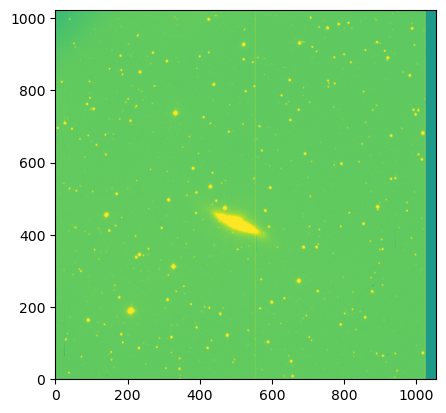

In [39]:
im = fits.open('/Users/wanyan/Desktop/Astro/229/M82/obj0061.fits')[0].data

plt.imshow(im, origin='lower', vmin=1000, vmax=5000)

## Scale the individual frames

In [37]:
# Already Did in the Combing Part

## Cosmic Rays

Text(55, 55, '')

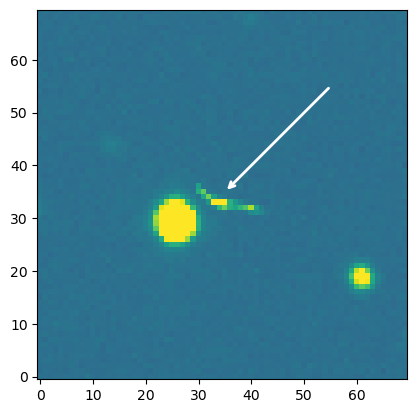

In [40]:
# plot the image zooming in on the cosmic ray
plt.imshow(im[900:970,650:720], origin='lower', vmin=3000, vmax=5750)
# plot an arrow to point out the cosmic ray
plt.annotate("", xytext=(55, 55), xy=(35, 35),
            arrowprops=dict(arrowstyle="->", color='white', lw=2))

Text(155, 155, '')

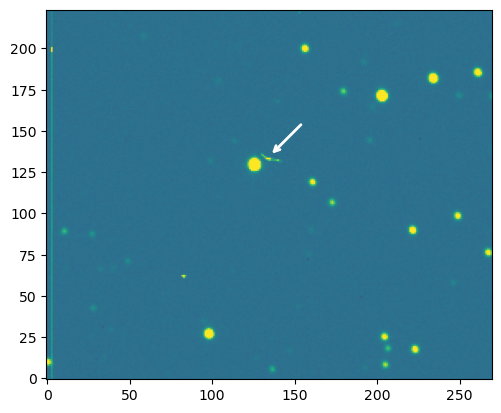

In [41]:

# plot the image zooming in on the cosmic ray
plt.imshow(im[800:1070,550:820], origin='lower', vmin=3000, vmax=5750)
# plot an arrow to point out the cosmic ray
plt.annotate("", xytext=(155, 155), xy=(135, 135),
            arrowprops=dict(arrowstyle="->", color='white', lw=2))

Text(155, 105, '')

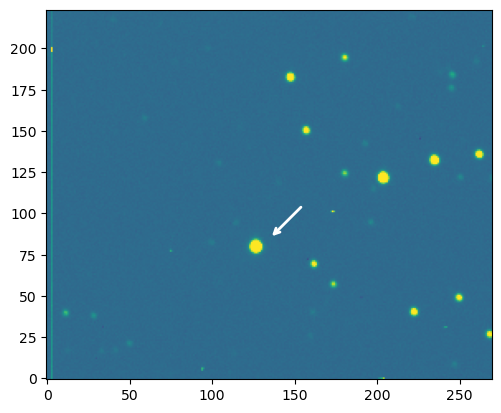

In [42]:
im2 = fits.open('/Users/wanyan/Desktop/Astro/229/M82/obj0060.fits')[0].data

# plot the image zooming in on the cosmic ray
plt.imshow(im2[800:1070,550:820], origin='lower', vmin=3000, vmax=5750)
# plot an arrow to point out the cosmic ray
plt.annotate("", xytext=(155, 105), xy=(135, 85),
            arrowprops=dict(arrowstyle="->", color='white', lw=2))

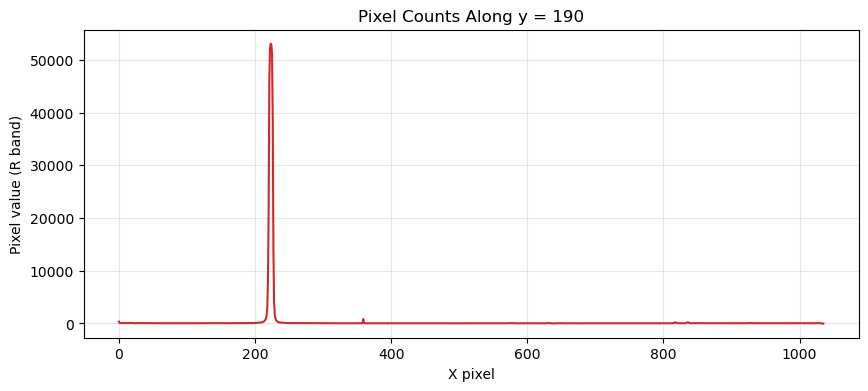

In [43]:
# suspect bad pixel

fits_path = '/Users/wanyan/Desktop/Astro/229/M82/reduced/R_band_trimmed.fits'

# open and load data
with fits.open(fits_path) as hdul:
    data = hdul[0].data

# select the horizontal row at y ≈ 190
y = 190
row = data[y, :]  # all x for fixed y

# plot the intensity along x
plt.figure(figsize=(10, 4))
plt.plot(row, color='tab:red')
plt.title(f'Pixel Counts Along y = {y}')
plt.xlabel('X pixel')
plt.ylabel('Pixel value (R band)')
plt.grid(True, alpha=0.3)
plt.show()


## Three Color Image

#### B band

The B-band Files are objects 59-62

In [68]:
# read in the first image
path = '/Users/wanyan/Desktop/Astro/229/M82/reduced/'
dat_B = path + 'imput_B.txt'

# files we need to do the alignment
bdat = ascii.read(dat_B, delimiter=" ") # reads into astropy table object bdat


ffile=fits.open(path+bdat['name'][0])

# determine the image size using the shape function
ysz, xsz = ffile[0].data.shape

# compute the shift needed for each image
xshift = bdat['xsh']
yshift = bdat['ysh']

#make an empty array to collect the big, shifted images
data_stackB = []

start_time = time.time()

# --- SKY SUBTRACTION PART ---
sky_box = ffile[0].data[496:517, 500:516]
sky_med = np.median(sky_box)

# notice that we start with image 1! image 0 is the reference image and does not need to be shifted
for i in range(1,4):
    #read in the image
    ffile = fits.open(path+bdat['name'][i])
    fdata = ffile[0].data
    fdata = fdata - sky_med

    # add NaNs around the edge of the image so we can shift the images without the data wrapping around on itself
    bgim = np.pad(fdata, 100, constant_values=np.nan)

    # shift the image -- make sure the x and y axes are correctly mapped!
    shift_im = np.roll(bgim, (xshift[i],yshift[i]), axis=(1,0))

    # add to the data stack
    data_stackB.append(shift_im)

# make the data stack into an array so we can do math with it
data_stackB = np.array(data_stackB)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.08792495727539062 seconds ---


In [80]:
start_time = time.time()
# take the median of the image through the stack direction
# notice that we use np.nanmedian() so that we get the correct medians even where there are NaNs
imstackB = np.nanmedian(data_stackB, axis=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.2951481342315674 seconds ---


/var/folders/jt/pmnf348x4bq6l0mthmr86gd00000gn/T/ipykernel_5281/425778597.py:4: RuntimeWarning: All-NaN slice encountered
  imstackB = np.nanmedian(data_stackB, axis=0)


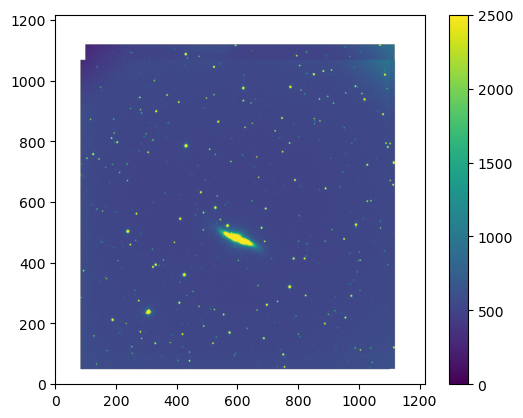

In [81]:
plt.Figure(figsize=(12,8))
plt.imshow(imstackB, origin='lower', vmin=0, vmax=2500)
plt.colorbar()

/var/folders/jt/pmnf348x4bq6l0mthmr86gd00000gn/T/ipykernel_5281/3438190606.py:2: RuntimeWarning: Mean of empty slice
  imB = np.nanmean(data_stackB, axis=0)


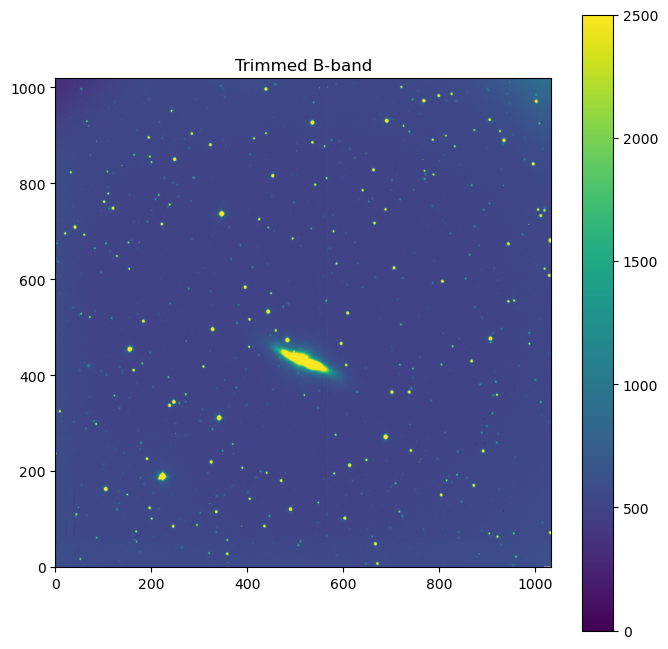

In [100]:
# Trim the Image
imB = np.nanmean(data_stackB, axis=0)

# Find rows/cols that contain valid data
valid_rows = np.any(~np.isnan(imB), axis=1)
valid_cols = np.any(~np.isnan(imB), axis=0)

# Get bounding box
rmin, rmax = np.where(valid_rows)[0][[0, -1]]
cmin, cmax = np.where(valid_cols)[0][[0, -1]]

# Trim
trimmed_imB = imB[rmin:rmax+1, cmin:cmax+1]

# Show result
plt.figure(figsize=(8,8))
plt.imshow(trimmed_imB[:1020, :], origin='lower', vmin=0, vmax=2500)
plt.colorbar()
plt.title('Trimmed B-band')
plt.show()

In [104]:
# Save the file

save_pathB = '/Users/wanyan/Desktop/Astro/229/M82/reduced/trim_B.fits'

trimmed_imB_clean = np.nan_to_num(trimmed_imB, nan=0.0)

hdu = fits.PrimaryHDU(trimmed_imB_clean[:1020, :])

hdu.writeto(save_pathB, overwrite=True)

print(f"Saved trimmed B-band FITS to:\n{save_pathB}")

Saved trimmed B-band FITS to:
/Users/wanyan/Desktop/Astro/229/M82/reduced/trim_B.fits


#### V band

The V-band files are 63, 64, and 66

In [85]:
# read in the first image
path = '/Users/wanyan/Desktop/Astro/229/M82/reduced/'
dat_V = path + 'imput_V.txt'

# files we need to do the alignment
vdat = ascii.read(dat_V, delimiter=" ") # reads into astropy table object vdat


ffile=fits.open(path+vdat['name'][0])

# determine the image size using the shape function
ysz, xsz = ffile[0].data.shape

# compute the shift needed for each image
xshift = vdat['xsh']
yshift = vdat['ysh']

#make an empty array to collect the big, shifted images
data_stackV = []

start_time = time.time()

# --- SKY SUBTRACTION PART ---
sky_box = ffile[0].data[496:517, 500:516]
sky_med = np.median(sky_box)

# notice that we start with image 1! image 0 is the reference image and does not need to be shifted
for i in range(1,3):
    #read in the image
    ffile = fits.open(path+vdat['name'][i])
    fdata = ffile[0].data
    fdata = fdata - sky_med

    # add NaNs around the edge of the image so we can shift the images without the data wrapping around on itself
    bgim = np.pad(fdata, 100, constant_values=np.nan)

    # shift the image -- make sure the x and y axes are correctly mapped!
    shift_im = np.roll(bgim, (xshift[i],yshift[i]), axis=(1,0))

    # add to the data stack
    data_stackV.append(shift_im)

# make the data stack into an array so we can do math with it
data_stackV = np.array(data_stackV)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.045603275299072266 seconds ---


In [86]:
start_time = time.time()
# take the median of the image through the stack direction
# notice that we use np.nanmedian() so that we get the correct medians even where there are NaNs
imstackV = np.nanmedian(data_stackV, axis=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.25347900390625 seconds ---


/var/folders/jt/pmnf348x4bq6l0mthmr86gd00000gn/T/ipykernel_5281/9207803.py:4: RuntimeWarning: All-NaN slice encountered
  imstackV = np.nanmedian(data_stackV, axis=0)


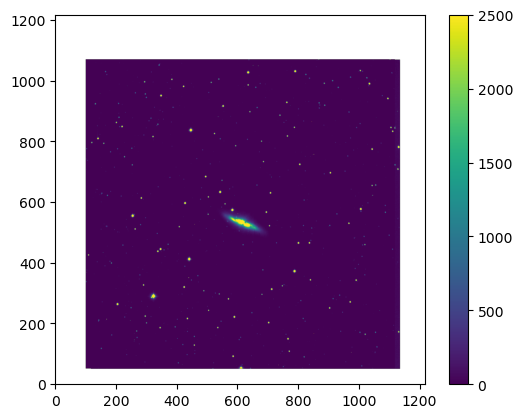

In [87]:
plt.Figure(figsize=(12,8))
plt.imshow(imstackV, origin='lower', vmin=0, vmax=2500)
plt.colorbar()

/var/folders/jt/pmnf348x4bq6l0mthmr86gd00000gn/T/ipykernel_5281/2507554600.py:2: RuntimeWarning: Mean of empty slice
  imV = np.nanmean(data_stackV, axis=0)


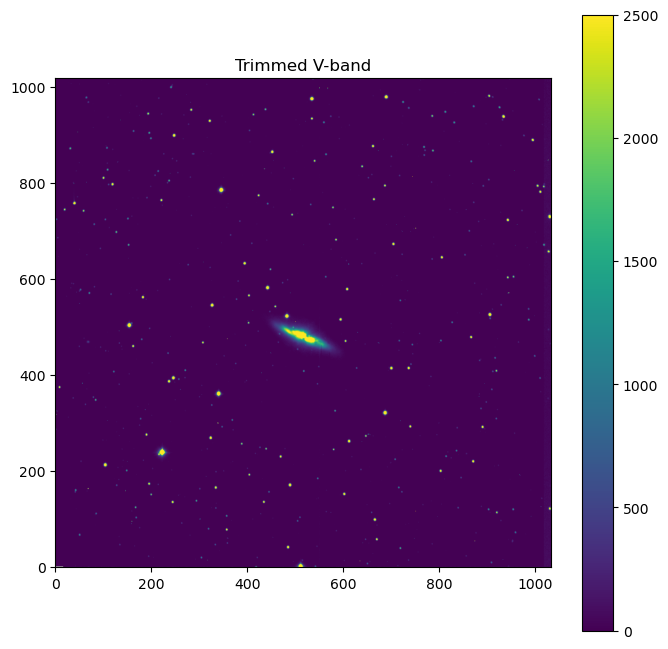

In [102]:
# Trim the Image
imV = np.nanmean(data_stackV, axis=0)

# Find rows/cols that contain valid data
valid_rows = np.any(~np.isnan(imV), axis=1)
valid_cols = np.any(~np.isnan(imV), axis=0)

# Get bounding box
rmin, rmax = np.where(valid_rows)[0][[0, -1]]
cmin, cmax = np.where(valid_cols)[0][[0, -1]]

# Trim
trimmed_imV = imV[rmin:rmax+1, cmin:cmax+1]

# Show result
plt.figure(figsize=(8,8))
plt.imshow(trimmed_imV, origin='lower', vmin=0, vmax=2500)
plt.colorbar()
plt.title('Trimmed V-band')
plt.show()

In [105]:
# Save the file

save_pathV = '/Users/wanyan/Desktop/Astro/229/M82/reduced/trim_V.fits'

trimmed_imV_clean = np.nan_to_num(trimmed_imV, nan=0.0)

hdu = fits.PrimaryHDU(trimmed_imV_clean[:1020, :])

hdu.writeto(save_pathV, overwrite=True)

print(f"Saved trimmed V-band FITS to:\n{save_pathV}")

Saved trimmed V-band FITS to:
/Users/wanyan/Desktop/Astro/229/M82/reduced/trim_V.fits


#### R band

The R-band Files are obj67-70

In [121]:
# read in the first image
path = '/Users/wanyan/Desktop/Astro/229/M82/reduced/'
dat_R = path + 'imput_R.txt'

# files we need to do the alignment
rdat = ascii.read(dat_R, delimiter=" ") # reads into astropy table object rdat


ffile=fits.open(path+rdat['name'][0])

# determine the image size using the shape function
ysz, xsz = ffile[0].data.shape

# compute the shift needed for each image
xshift = rdat['xsh']
yshift = rdat['ysh']

#make an empty array to collect the big, shifted images
data_stackR = []

start_time = time.time()

# --- SKY SUBTRACTION PART ---
sky_box = ffile[0].data[496:517, 500:516]
sky_med = np.median(sky_box)

# notice that we start with image 1! image 0 is the reference image and does not need to be shifted
for i in range(1,4):
    #read in the image
    ffile = fits.open(path+rdat['name'][i])
    fdata = ffile[0].data
    fdata = fdata - sky_med

    # add NaNs around the edge of the image so we can shift the images without the data wrapping around on itself
    bgim = np.pad(fdata, 100, constant_values=np.nan)

    # shift the image -- make sure the x and y axes are correctly mapped!
    shift_im = np.roll(bgim, (xshift[i],yshift[i]), axis=(1,0))

    # add to the data stack
    data_stackR.append(shift_im)

# make the data stack into an array so we can do math with it
data_stackR = np.array(data_stackR)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.09172773361206055 seconds ---


In [122]:
start_time = time.time()
# take the median of the image through the stack direction
# notice that we use np.nanmedian() so that we get the correct medians even where there are NaNs
imstackR = np.nanmedian(data_stackR, axis=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.25190234184265137 seconds ---


/var/folders/jt/pmnf348x4bq6l0mthmr86gd00000gn/T/ipykernel_5281/567462081.py:4: RuntimeWarning: All-NaN slice encountered
  imstackR = np.nanmedian(data_stackR, axis=0)


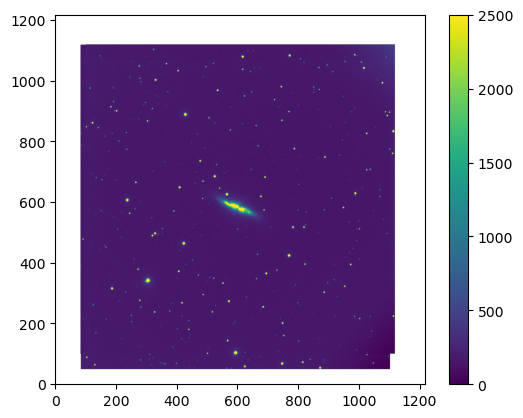

In [123]:
plt.Figure(figsize=(12,8))
plt.imshow(imstackR, origin='lower', vmin=0, vmax=2500)
plt.colorbar()

/var/folders/jt/pmnf348x4bq6l0mthmr86gd00000gn/T/ipykernel_5281/2525241800.py:2: RuntimeWarning: Mean of empty slice
  imR = np.nanmean(data_stackR, axis=0)


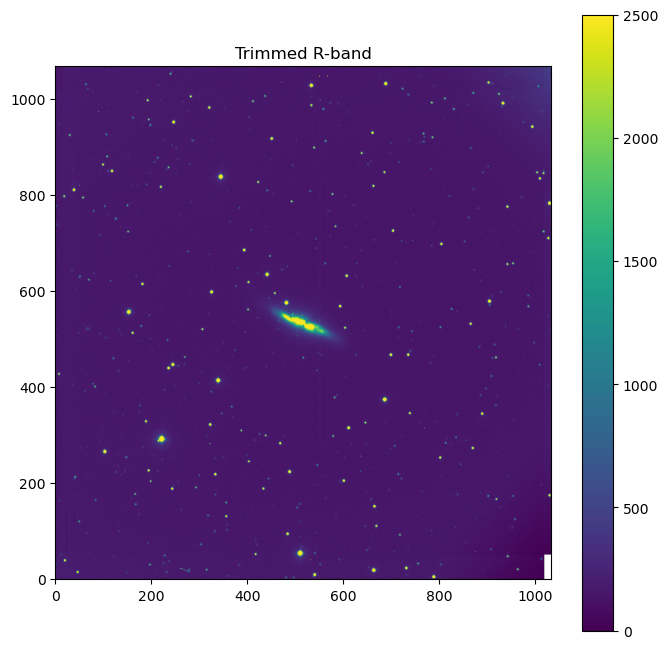

In [124]:
# Trim the Image
imR = np.nanmean(data_stackR, axis=0)

# Find rows/cols that contain valid data
valid_rows = np.any(~np.isnan(imR), axis=1)
valid_cols = np.any(~np.isnan(imR), axis=0)

# Get bounding box
rmin, rmax = np.where(valid_rows)[0][[0, -1]]
cmin, cmax = np.where(valid_cols)[0][[0, -1]]

# Trim
trimmed_imR = imR[rmin:rmax+1, cmin:cmax+1]

# Show result
plt.figure(figsize=(8,8))
plt.imshow(trimmed_imR, origin='lower', vmin=0, vmax=2500)
plt.colorbar()
plt.title('Trimmed R-band')
plt.show()

/var/folders/jt/pmnf348x4bq6l0mthmr86gd00000gn/T/ipykernel_5281/2045478435.py:4: RuntimeWarning: Mean of empty slice
  imR = np.nanmean(data_stackR, axis=0)


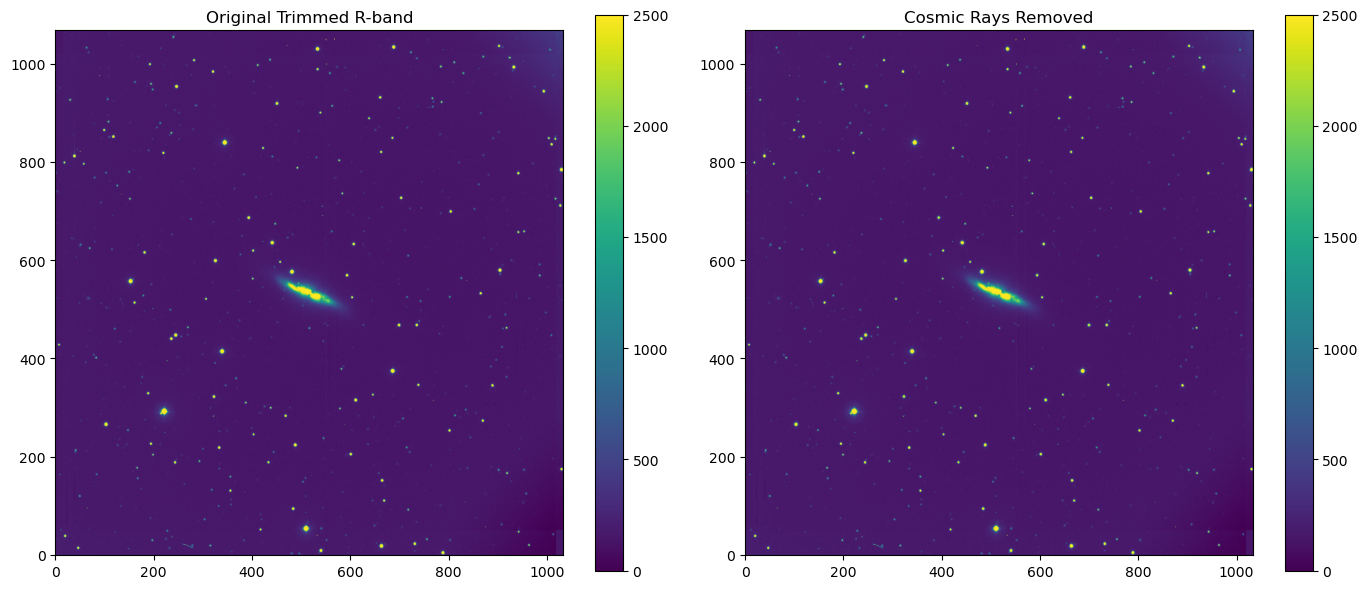

In [162]:
# Fix the Cosmic Rays Experiment
from scipy.ndimage import median_filter, gaussian_filter, laplace

imR = np.nanmean(data_stackR, axis=0)

valid_rows = np.any(~np.isnan(imR), axis=1)
valid_cols = np.any(~np.isnan(imR), axis=0)
rmin, rmax = np.where(valid_rows)[0][[0, -1]]
cmin, cmax = np.where(valid_cols)[0][[0, -1]]

trimmed = imR[rmin:rmax+1, cmin:cmax+1]

nan_mask = np.isnan(trimmed)
if np.any(nan_mask):
    med_val = np.nanmedian(trimmed)
    trimmed[nan_mask] = med_val

smooth = gaussian_filter(trimmed, sigma=1)

sharp = trimmed - smooth

lap = laplace(sharp)

sigma = np.std(lap)
threshold = 7 * sigma   

cr_mask = lap > threshold

median_img = median_filter(trimmed, size=5)

clean = trimmed.copy()
clean[cr_mask] = median_img[cr_mask]

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(trimmed, origin='lower', cmap='viridis', vmin=0, vmax=2500)
plt.title("Original Trimmed R-band")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(clean, origin='lower', cmap='viridis', vmin=0, vmax=2500)
plt.title("Cosmic Rays Removed")
plt.colorbar()

plt.tight_layout()
plt.show()



In [127]:
# Save the file

save_pathR = '/Users/wanyan/Desktop/Astro/229/M82/reduced/trim_R.fits'

trimmed_imR_clean = np.nan_to_num(trimmed_imR, nan=0.0)

hdu = fits.PrimaryHDU(trimmed_imR_clean[:1020, :])

hdu.writeto(save_pathV, overwrite=True)

print(f"Saved trimmed V-band FITS to:\n{save_pathR}")

Saved trimmed R-band FITS to:
/Users/wanyan/Desktop/Astro/229/M82/reduced/trim_R.fits


### Combine the Images

#### Alignment

In [130]:
from astropy.visualization import AsinhStretch, simple_norm

# ---------------------------------------------------------------------
# Configuration
# ---------------------------------------------------------------------
path = '/Users/wanyan/Desktop/Astro/229/M82/reduced/'
shift_table = os.path.join(path, 'image_shift.txt')
cube_fn = os.path.join(path, 'M82_rgb_cube.fits')
png_fn = os.path.join(path, 'M82_rgb.png')
preview_fn = os.path.join(path, 'M82_rgb_display.png')
pad = 200  # extra border before shifting so data never wraps

# ---------------------------------------------------------------------
# Read the shift table (header line starts with '#')
# ---------------------------------------------------------------------
rdat = ascii.read(
    shift_table,
    format='basic',
    delimiter=' ',
    guess=False,
    data_start=1,
    names=('name', 'xsh', 'ysh')
)

names = np.array(rdat['name'], dtype=str)
xshift = np.array(rdat['xsh'], dtype=float)
yshift = np.array(rdat['ysh'], dtype=float)

# Ensure the B-band exists (use it as the reference if missing)
if 'trim_B.fits' not in names:
    names = np.insert(names, 0, 'trim_B.fits')
    xshift = np.insert(xshift, 0, 0.0)
    yshift = np.insert(yshift, 0, 0.0)

print('Shift table loaded / adjusted:')
for n, dx, dy in zip(names, xshift, yshift):
    print(f'{n:15s}  xsh={dx:7.2f}  ysh={dy:7.2f}')

# ---------------------------------------------------------------------
# Sky subtraction reference (first image in the list)
# ---------------------------------------------------------------------
ref_path = os.path.join(path, names[0])
with fits.open(ref_path) as ref_hdul:
    ref_img = ref_hdul[0].data.astype(float)

# Adjust these indices for your preferred sky region
sky_box = ref_img[496:517, 500:516]
sky_med = np.median(sky_box)
print(f'Sky median from reference image: {sky_med:.3f}')

# ---------------------------------------------------------------------
# Align every band relative to the first entry
# ---------------------------------------------------------------------
aligned = []
shapes = []
start_time = time.time()

for fname, dx, dy in zip(names, xshift, yshift):
    with fits.open(os.path.join(path, fname)) as hdul:
        img = hdul[0].data.astype(float)

    img -= sky_med                      # uniform sky subtraction
    img = np.nan_to_num(img, nan=0.0)   # clear NaNs before padding
    padded = np.pad(img, pad_width=pad, mode='constant', constant_values=np.nan)

    rel_dx = int(round(dx - xshift[0]))
    rel_dy = int(round(dy - yshift[0]))
    shifted = np.roll(padded, shift=(rel_dy, rel_dx), axis=(0, 1))

    aligned.append(shifted)
    shapes.append(shifted.shape)

print(f'Read and shifted {len(aligned)} images in {time.time() - start_time:.2f}s')

# Pad lower/right edges so every plane has the same shape
max_y = max(s[0] for s in shapes)
max_x = max(s[1] for s in shapes)
for i, arr in enumerate(aligned):
    dy = max_y - arr.shape[0]
    dx = max_x - arr.shape[1]
    if dy or dx:
        aligned[i] = np.pad(arr, ((0, dy), (0, dx)), mode='constant', constant_values=np.nan)

aligned = np.array(aligned)
print(f'Aligned stack shape: {aligned.shape}')

# ---------------------------------------------------------------------
# Trim to region where all bands have valid data
# ---------------------------------------------------------------------
mask = np.all(~np.isnan(aligned), axis=0)
ys, xs = np.where(mask)

if ys.size == 0 or xs.size == 0:
    raise RuntimeError('No overlapping region found; check shift values or pad size.')

ymin, ymax = ys.min(), ys.max() + 1
xmin, xmax = xs.min(), xs.max() + 1
print(f'Trim bounds: x=[{xmin}:{xmax}], y=[{ymin}:{ymax}]')

trimmed = aligned[:, ymin:ymax, xmin:xmax]
print(f'Trimmed stack shape: {trimmed.shape}')

# ---------------------------------------------------------------------
# Save each trimmed image (all have identical dimensions now)
# ---------------------------------------------------------------------
trimmed_paths = {}
for fname, data in zip(names, trimmed):
    cleaned = np.nan_to_num(data, nan=0.0)
    save_path = os.path.join(path, f'aligned_trim_{fname}')
    fits.PrimaryHDU(cleaned).writeto(save_path, overwrite=True)
    trimmed_paths[fname] = save_path
    print(f'Saved {save_path}')


Shift table loaded / adjusted:
trim_B.fits      xsh=   0.00  ysh=   0.00
trim_V.fits      xsh=  -2.00  ysh= -49.00
trim_R.fits      xsh=  -3.00  ysh= -47.00
Sky median from reference image: 514.029
Read and shifted 3 images in 0.06s
Aligned stack shape: (3, 1420, 1434)
Trim bounds: x=[200:1231], y=[200:1170]
Trimmed stack shape: (3, 970, 1031)
Saved /Users/wanyan/Desktop/Astro/229/M82/reduced/aligned_trim_trim_B.fits
Saved /Users/wanyan/Desktop/Astro/229/M82/reduced/aligned_trim_trim_V.fits
Saved /Users/wanyan/Desktop/Astro/229/M82/reduced/aligned_trim_trim_R.fits


#### Make the image

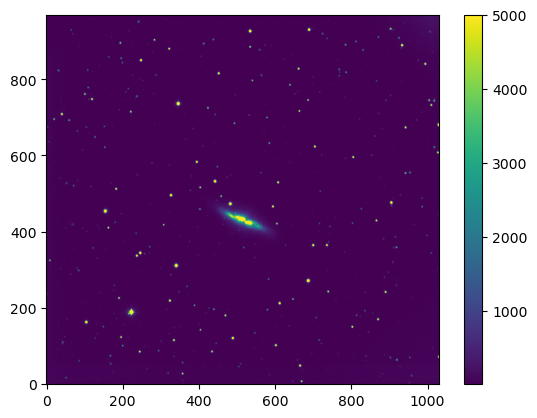

In [137]:
f657n_fn = '/Users/wanyan/Desktop/Astro/229/M82/reduced/aligned_B.fits'
f673n_fn = '/Users/wanyan/Desktop/Astro/229/M82/reduced/aligned_V.fits'
f502n_fn = '/Users/wanyan/Desktop/Astro/229/M82/reduced/aligned_R.fits'

f657n = fits.open(f657n_fn)


plt.imshow(f657n[0].data, origin='lower', vmin=10, vmax=5000)
plt.colorbar()
     

In [138]:
# Make a 3D cube with the images in RGB order
aplpy.make_rgb_cube([f673n_fn, f657n_fn, f502n_fn], path+'M82_cube.fits')

# Make an RGB image
aplpy.make_rgb_image(path+'M82_cube.fits', path+'M82_rgb.png')

INFO: Red: [aplpy.rgb]
INFO: vmin = -6.491e+02 (auto) [aplpy.rgb]
INFO: vmax =  1.490e+03 (auto) [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin = -4.148e+01 (auto) [aplpy.rgb]
INFO: vmax =  3.168e+03 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin = -4.736e+02 (auto) [aplpy.rgb]
INFO: vmax =  9.973e+02 (auto) [aplpy.rgb]


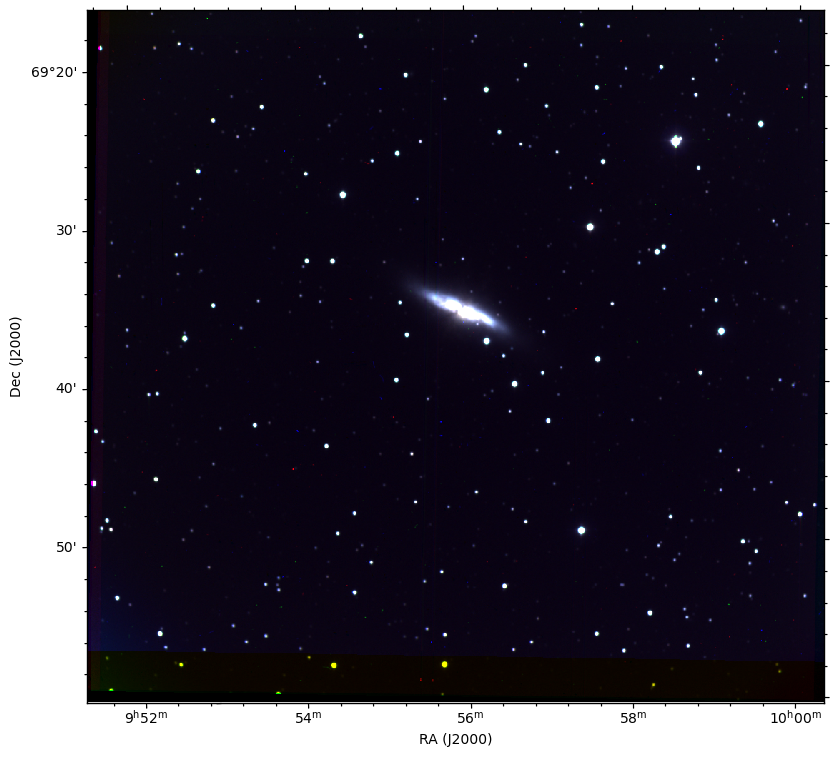

In [139]:
# Plot the RGB image using one of the three images to indicate the projection
f = aplpy.FITSFigure(f657n_fn)
f.show_rgb(path+'M82_rgb.png')

In [140]:

# Make an RGB image
aplpy.make_rgb_image(path+'M82_cube.fits', path+'M82_rgb.png',
                     vmin_g=10, vmax_r=5000)
     

INFO: Red: [aplpy.rgb]
INFO: vmin = -6.507e+02 (auto) [aplpy.rgb]
INFO: vmax =  5.000e+03 [aplpy.rgb]
INFO: Green: [aplpy.rgb]
INFO: vmin =  1.000e+01 [aplpy.rgb]
INFO: vmax =  2.957e+03 (auto) [aplpy.rgb]
INFO: Blue: [aplpy.rgb]
INFO: vmin = -4.712e+02 (auto) [aplpy.rgb]
INFO: vmax =  1.575e+03 (auto) [aplpy.rgb]


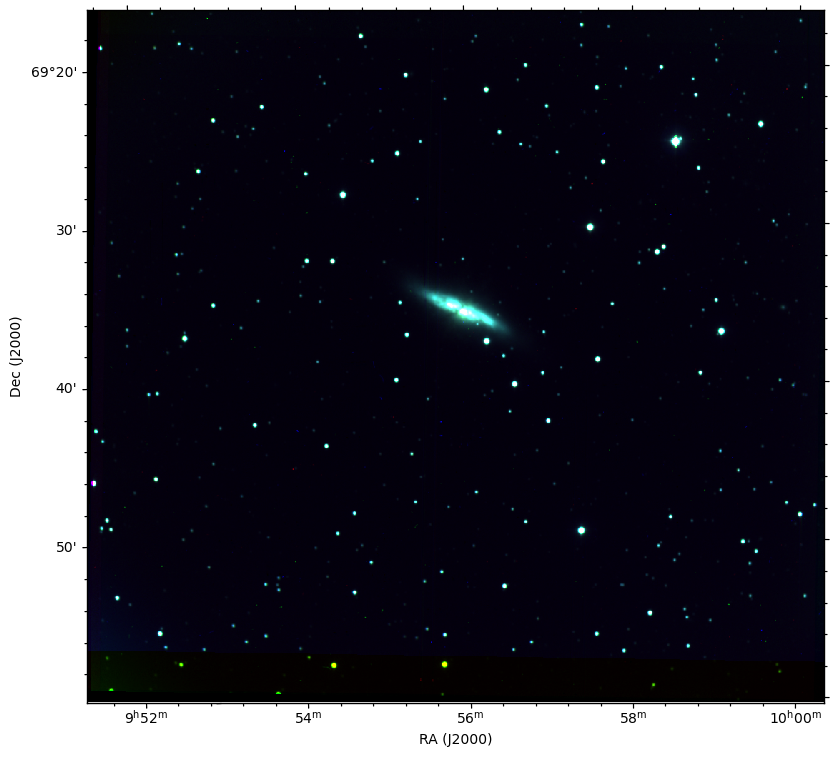

In [141]:
# Plot the RGB image using one of the three images to indicate the projection
f = aplpy.FITSFigure(f657n_fn)
f.show_rgb(path+'M82_rgb.png')

In [158]:
# Trim the final images for the M82
from PIL import Image

path = '/Users/wanyan/Desktop/Astro/229/M82/reduced/'
png_in = path + 'M82_rgb.png'
png_out = path + 'M82_rgb_zoomed.png'

# --- Parameters ---
zoom_factor = 2.0  # >1 means zoom in (2.0 = 2× zoom)
output_size = (1100, 980)  # size of output image (same as before)

# --- Load image ---
img = Image.open(png_in)
w, h = img.size

# --- Compute central crop box ---
crop_w = w / zoom_factor
crop_h = h / zoom_factor
left = (w - crop_w) / 2
top = (h - crop_h) / 2
right = left + crop_w
bottom = top + crop_h

# --- Crop and resize back up ---
img_zoomed = img.crop((left, top, right, bottom)).resize(output_size, Image.Resampling.LANCZOS)

# --- Save ---
img_zoomed.save(png_out)
print(f'Zoomed center image saved to {png_out}')


Zoomed center image saved to /Users/wanyan/Desktop/Astro/229/M82/reduced/M82_rgb_zoomed.png
